In [2]:
%load_ext lab_black

In [3]:
# one hot encode runway
# ordinal encode airline
# TODO: Try with avg pb time, ratioH/M, ratio nominal
from traffic.core import Traffic

import pandas as pd
import numpy as np
import pickle

import os.path

from ipyleaflet import Polygon
from ipywidgets import Layout
from ipyleaflet import Map, Marker

import altair as alt

from cartes.osm import Overpass

from sklearn import svm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

from numpy import mean
from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
from ground_analysis.build_features import gather_data

In [5]:
import matplotlib.pyplot as plt

In [6]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [135]:
dep_arr_df = pd.read_pickle("../data/processed/dep_arr_df5_sifiAqliScfi.pkl")

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
dep_arr_df = pd.read_pickle(
    "../data/processed/dep_arr_df12_onehotconfig_addedsifis.pkl"
)

In [9]:
twy_cols = [
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
]

In [10]:
df = dep_arr_df[twy_cols]

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [12]:
s = MinMaxScaler()
x = s.fit_transform(df)

In [13]:
n = 5
p = PCA(n_components=n).fit(x)

In [14]:
p.transform(x)[:, :1]

array([[-0.57287398],
       [-0.50360412],
       [-0.50360412],
       ...,
       [-0.48078683],
       [-0.46297698],
       [-0.57287398]])

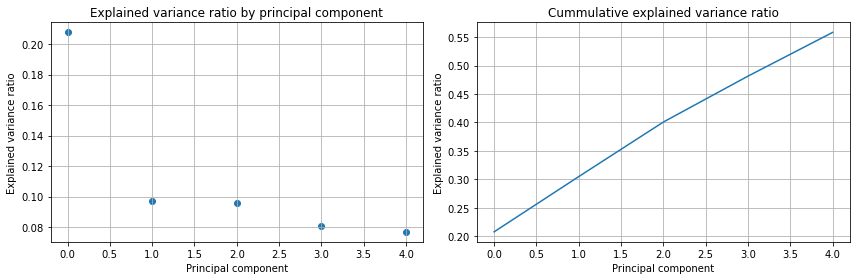

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(p.n_components_), p.explained_variance_ratio_)
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Explained variance ratio by principal component")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(p.explained_variance_ratio_.cumsum())
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Cummulative explained variance ratio")
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
import seaborn as sns

<AxesSubplot:>

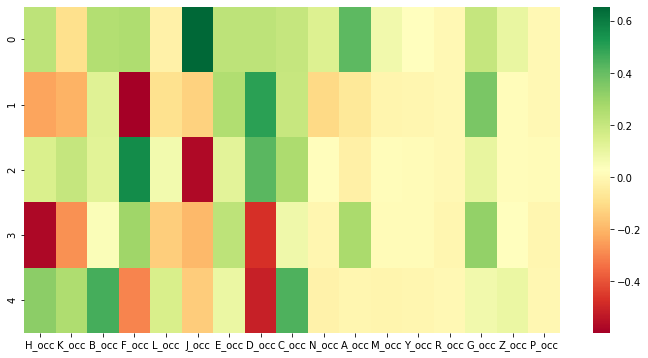

In [20]:
m = pd.DataFrame(p.components_, columns=twy_cols)
plt.figure(figsize=(12, 6))
sns.heatmap(m, cmap="RdYlGn")

In [21]:
datachart = dep_arr_df.query("end_pb==end_pb & mvt_type=='DEP'")[
    ["total_holding_time_minutes", "E_occ"]
]
alt.Chart(datachart).mark_boxplot(outliers=False).encode(
    x=alt.X("E_occ:O", title="Taxiway E max occupancy"),
    y=alt.Y("total_holding_time_minutes:Q", title="Additional TXOT"),
)

alt.Chart(...)

In [22]:
names = [f"twy_pca{i}" for i in range(n)]
dep_arr_df[names] = p.transform(dep_arr_df[twy_cols])

['twy_pca4', 'twy_pca3', 'twy_pca2', 'twy_pca1', 'twy_pca0']

In [40]:
datachart = dep_arr_df.query("mvt_type=='DEP' & parking_position==parking_position")[
    names + ["taxi_holding_time_minutes", "avg_delay_30min"]
]
# alt.Chart(datachart).mark_point(opacity=0.25).encode(x="")

alt.Chart(datachart).mark_circle(opacity=0.2).encode(
    alt.X(alt.repeat("column"), type="quantitative"),
    alt.Y(alt.repeat("row"), type="quantitative"),
    color="taxi_holding_time_minutes:Q",
).properties(width=150, height=150).repeat(row=names, column=names[::-1])

alt.RepeatChart(...)

In [126]:
dep_arr_df[["twy_pca1"]] = p.transform(dep_arr_df[twy_cols])[:, :1]

In [155]:
datachart = dep_arr_df.query("mvt_type=='DEP'")[["nextAvgDelay"] + names]
alt.Chart(datachart).transform_fold(names).mark_boxplot(outliers=False).encode(
    x=alt.X("value:Q", bin=True),
    y=alt.Y("nextAvgDelay"),
    facet="key:N",
)

alt.Chart(...)

In [149]:
dep_arr_df.query("mvt_type=='DEP'")[["nextAvgDelay"] + names]

nextAvgDelay  twy_pca0  twy_pca1  twy_pca2  twy_pca3  twy_pca4
0          3.455556 -0.495381 -0.120744  0.024089 -0.093394  0.070784
1          3.925000 -0.495381 -0.120744  0.024089 -0.093394  0.070784
10         5.710000 -0.495381 -0.120744  0.024089 -0.093394  0.070784
12         5.735000 -0.272512  0.922314 -0.254327 -0.074277  0.041433
14         5.913333 -0.272512  0.922314 -0.254327 -0.074277  0.041433
...             ...       ...       ...       ...       ...       ...
36003      7.656667 -0.293668  0.195863 -0.452541  0.973417 -0.330989
36005      9.105556 -0.031670  0.005873  0.075960  0.631869 -0.255734
36006      9.105556 -0.031670  0.005873  0.075960  0.631869 -0.255734
36008      9.105556 -0.228110  0.021835 -0.298633  0.642378 -0.116412
36009      9.105556 -0.495381 -0.120744  0.024089 -0.093394  0.070784

[16932 rows x 6 columns]

# UMAP attempt

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
import umap

reducer = umap.UMAP()

In [43]:
df = dep_arr_df[twy_cols]

In [44]:
s = StandardScaler()
x = s.fit_transform(df)

In [46]:
p = reducer.fit_transform(x)

In [47]:
p

array([[ -2.9358149, -13.7104225],
       [ 13.918088 ,  -8.542179 ],
       [ 13.928099 ,  -8.554364 ],
       ...,
       [-12.941049 ,   4.684585 ],
       [-12.276614 ,  17.401005 ],
       [ -2.775644 , -13.831983 ]], dtype=float32)

In [48]:
dep_arr_df[["twy_umap0", "twy_umap1"]] = p  # .transform(dep_arr_df[twy_cols])

In [53]:
names = ["twy_umap0", "twy_umap1"]

datachart = dep_arr_df.query("mvt_type=='DEP' & parking_position==parking_position")[
    names + ["taxi_holding_time_minutes", "avg_delay_30min"]
]
# alt.Chart(datachart).mark_point(opacity=0.25).encode(x="")


alt.Chart(datachart).mark_circle(opacity=0.05).encode(
    alt.X(alt.repeat("column"), type="quantitative"),
    alt.Y(alt.repeat("row"), type="quantitative"),
    color="avg_delay_30min:Q",
).properties(width=150, height=150).repeat(row=names, column=names[::-1])

alt.RepeatChart(...)